In [1]:
import os
import torch
from PIL import Image
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def test_eval(model, test_path, test_class, transform):
  ans = []
  files = test_class.keys()
  labels = test_class.values()
  num_correct = 0
  for file , idx in zip(files, labels):
      path = os.path.join(test_path, file)
      try:
          img = Image.open(path)
          tensor = transform(img)
          temp_new_path = file.split('.')[0] + '.png'
          new_path = os.path.join(test_path, temp_new_path)
          img.save(new_path)
          img_file = Image.open(new_path).convert('RGB')
          tensor_img = transform(img_file)
          tensor = tensor.unsqueeze(0).to(device)
          output = model(tensor)
          confidence, prediction = torch.max(output, 1)
          ans.append(prediction.tolist()[0])
          if prediction == idx:
            num_correct += 1
      except RuntimeError as e:
          print('could not infer dtype of JPEG')
  return ans, (num_correct/len(test_class))

In [3]:
def get_test_reults(model, transform, test_path, save_as):
    preds = []
    files = os.listdir(test_path)
    for file in files:
        path = os.path.join(test_path, file)
        try:
            img = Image.open(path)
            temp_new_path = file.split('.')[0] + '.png'
            new_path = os.path.join(test_path, temp_new_path)
            img.save(new_path)
            img_file = Image.open(new_path).convert('RGB')
            tensor_image = transform(img_file)
            tensor = tensor_image.unsqueeze(0).to(device)
            output = model(tensor)
            _, prediction = torch.max(output, 1)
            preds.append(prediction.tolist()[0])
        except RuntimeError as e:
            print('could not infer dtype of JPEG, skipping ...')
    
    if save_as:
        save_dict = {
            'image_name: ': files,
            'predicted_class': preds}
        df = pd.DataFrame(save_dict)
        df.to_csv(save_as)
    return preds

In [4]:
vgg19_path = '/home/anindya/Documents/kaggle/SAII/LAST TRIAL/models/VGG19.pth'
vgg19_bn_path = '/home/anindya/Documents/kaggle/SAII/LAST TRIAL/models/VGG19_bn.pth'
resnet_path = '/home/anindya/Documents/kaggle/SAII/LAST TRIAL/models/RESNET152.pth'

In [5]:
import torch.nn as nn
from torchvision.models import vgg19_bn, vgg19, resnet152

### VGG19

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 6
model = resnet152(pretrained=False)
for param in model.parameters():
    param.requires_grad = False

#model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [7]:
# loading the model

pp = model.load_state_dict(torch.load(resnet_path, map_location=torch.device(device)))

In [11]:
import torchvision.transforms as transforms
test_path = '/home/anindya/Documents/kaggle/SAII/LAST TRIAL/test_folder'

test_class = {'in1.jpg'    : 0,
              'land3.jpg'  : 3,
              'in3.jpeg'   : 0,
              'earth1.jpeg': 0,
              'd1.jpeg'    : 3,
              'urb3.jpeg'  : 1,
              'd2.jpeg'    : 3,
              'urb2.jpeg'  : 1,
              'earth3.jpeg': 0,
              'land2.jpeg' : 3,
              'sea1.jpg'   : 4,
              'wild2.jpeg' : 1,
              'sea3.jpeg'  : 4,
              'earth4.jpeg': 0,
              'in2.jpeg'   : 0,
              'd4.jpg'     : 3,
              'earth5.jpeg': 0,
              'earth2.jpg' : 0,
              'd3.jpg'     : 3,
              'urb1.jpeg'  : 1,
              'sea2.jpeg'  : 5,
              'urb4.jpeg'  : 1,
              'wild3.jpeg' : 1,
              'wild1.jpg'  : 1,
              'land1.jpg'  : 3}


transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                                ])

In [9]:
import warnings
warnings.filterwarnings("ignore")

preds, acc = test_eval(model, test_path, test_class, transform)
print(acc)

0.44


<AxesSubplot:>

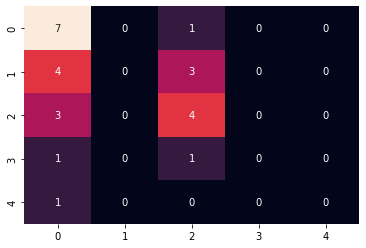

In [10]:
actual = list(test_class.values())

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual, preds)
sns.heatmap(cm, annot=True, cbar=False)

In [15]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(actual, preds, average='micro'))
print(recall_score(actual, preds, average='micro'))

0.44
0.44
